In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint

sys.path.append('../..')
from model.processing import query_sqlPad
time_range = ('2024-6-15T00:00:00.000Z', '2024-6-18T00:00:00.000Z')
tkn = 'DOT'
binance_tkn = 'DOT'

In [2]:
query = f"""
WITH normalized_trades AS (
  SELECT
    timestamp,
    block,
    who,
    operation,
    (SELECT symbol FROM token_metadata WHERE id = asset_in LIMIT 1) AS asset_in,
    (SELECT symbol FROM token_metadata WHERE id = asset_out LIMIT 1) AS asset_out,
    amount_in / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_in LIMIT 1)) AS amount_in,
    amount_out / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS amount_out,
    asset_fee_amount / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS asset_fee_amount,
    lrna_in / POWER(10, 12) as lrna_in,
    lrna_out / POWER(10, 12) as lrna_out,
    lrna_fee_amount / POWER(10, 12) as lrna_fee_amount,
    lrna_fee_amount / NULLIF(lrna_out, 0) as lrna_fee_rate,
    asset_fee_amount / NULLIF(amount_out, 0) as asset_fee_rate
  FROM (
    SELECT
      timestamp,
      block.height AS block,
      args->>'who' AS who,
      name AS operation,
      (args->>'assetIn')::integer AS asset_in,
      (args->>'assetOut')::integer AS asset_out,
      (args->>'amountIn')::numeric AS amount_in,
      (args->>'amountOut')::numeric AS amount_out,
      (args->>'hubAmountIn')::numeric as lrna_out,
      (args->>'hubAmountOut')::numeric as lrna_in,
      (args->>'assetFeeAmount')::numeric as asset_fee_amount,
      (args->>'protocolFeeAmount')::numeric as lrna_fee_amount
    FROM event
    INNER JOIN block ON block_id = block.id
    WHERE name LIKE 'Omnipool.%Executed'
      AND "timestamp" BETWEEN '{time_range[0]}' AND '{time_range[1]}'
  ) AS trades
),
trades AS (
  SELECT
    timestamp,
    block,
    amount_out as amount,
    lrna_in as lrna,
    (amount_out + asset_fee_amount) / NULLIF(lrna_in + lrna_fee_amount, 0) as price,
    asset_fee_rate as fee_rate,
    'asset' as fee_type,
    'sell' as direction,
    asset_in as other_asset
  FROM normalized_trades
  WHERE asset_out = '{tkn}'
  UNION ALL
  SELECT
    timestamp,
    block,
    amount_in as amount,
    lrna_out as lrna,
    amount_in / (lrna_out + lrna_fee_amount) as price,
    lrna_fee_rate as fee_rate,
    'LRNA' as fee_type,
    'buy' as direction,
    asset_out as other_asset
  FROM normalized_trades
  WHERE asset_in = '{tkn}'
)
SELECT
  block,
  amount,
  lrna,
  price,
  fee_rate,
  fee_type,
  direction,
  other_asset
FROM trades 
ORDER BY 1;
"""

In [3]:
trades_history = query_sqlPad(query)
last_trade = trades_history[0]
trades_history =  [
    last_trade := [*trade, trade[3] - last_trade[3]] 
    for trade in trades_history 
    if trade[3] != None
]
print("done")

waiting for query to finish...
done


In [4]:
def fill_blocks(data, index, first_block: int = None, last_block: int = None):
    relevant_data = {line[0]: float(line[index]) for line in data if line[index] is not None}
    min_block = min(relevant_data)
    if first_block is None:
        first_block = min_block
    elif first_block < min_block:
        relevant_data.update({block: relevant_data[min_block] for block in range(first_block, min_block)})
        
    max_block = max(relevant_data)
    if last_block is None:
        last_block = max_block
    elif last_block > max_block:
        relevant_data.update({block: relevant_data[max_block] for block in range(max_block, last_block)})
    
    last_item = None
    return [relevant_data.get(block, last_item := relevant_data.get(block, last_item)) for block in range(first_block, last_block + 1)]

def oraclize(raw_data, length = 10):
    decay_factor = 2 / (length + 1)
    oracle_current = raw_data[0]
    oracle_values = [oracle_current]
    for item in raw_data[1:]:
        oracle_current = oracle_current * (1 - decay_factor) + item * decay_factor
        oracle_values.append(oracle_current)
    return oracle_values

In [5]:
min_block = trades_history[0][0]
max_block = trades_history[-1][0]
lrna_fees = fill_blocks(filter(lambda x: x[5] == 'LRNA', trades_history), 4, min_block, max_block)
asset_fees = fill_blocks(filter(lambda x: x[5] == 'asset', trades_history), 4, min_block, max_block)
tkn_prices = fill_blocks(trades_history, 3)
blocks = list(range(min_block, max_block))

In [6]:
# get recorded market prices for the given time range
from model.processing import import_binance_prices, get_historical_omnipool_balance
start_date=datetime.strptime(time_range[0], '%Y-%m-%dT%H:%M:%S.%fZ')
end_date=datetime.strptime(time_range[1], '%Y-%m-%dT%H:%M:%S.%fZ')
historical_price_data = import_binance_prices(
    assets=[binance_tkn],
    start_date=datetime.strftime(start_date, "%B %d %Y"),
    days=math.ceil((end_date - start_date).total_seconds() / (24 * 60 * 60))
)

In [7]:
tkn_liquidity = get_historical_omnipool_balance(tkn, time_range[0])  # 2319659
tkn_lrna = tkn_liquidity / tkn_prices[0]

liquidity_history = [[min_block, tkn_liquidity]]
lrna_history = [[min_block, tkn_lrna]]

for trade in trades_history:
    liquidity_history.append([
        trade[0], liquidity_history[-1][1]
        - (trade[1] if trade[6] == 'sell' else -trade[1])
    ])
    lrna_history.append([
        trade[0], lrna_history[-1][1]
        - (trade[2] if trade[6] == 'buy' else -trade[2])
    ])
liquidity_history = fill_blocks(liquidity_history, 1)
lrna_history = fill_blocks(lrna_history, 1)

loading omnipool_history_05
Retrieved balance of DOT on 2024-06-15 00:00:00+00:00: 2024-06-15


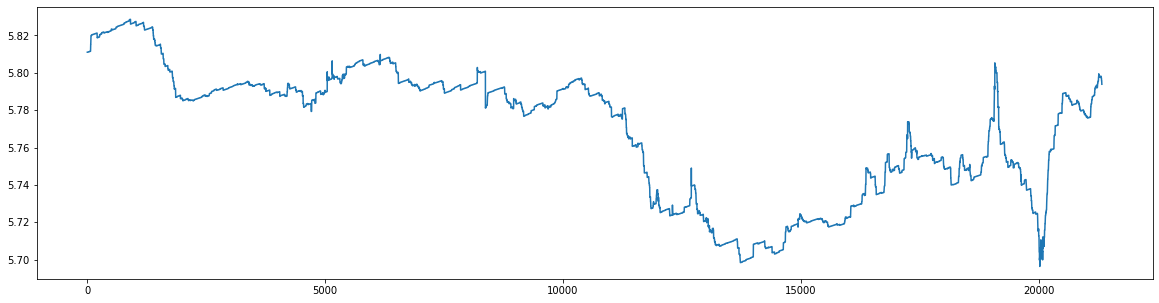

In [8]:
spot_price_history = [liquidity_history[i] / lrna_history[i] for i in range(len(blocks))]
plt.figure(figsize=(20, 5))
plt.plot(spot_price_history)

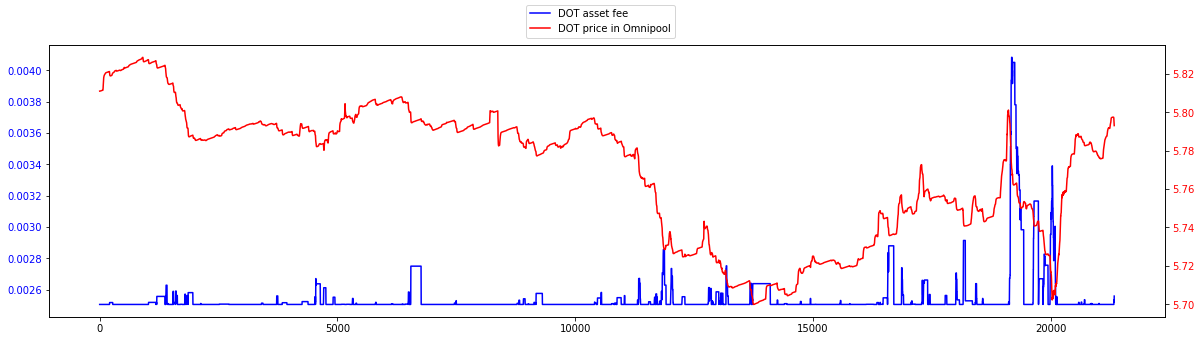

In [9]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(asset_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} asset fee")
ax2 = ax.twinx()
ax2.plot(oraclize(tkn_prices[view_range[0]: view_range[1]]), color='red', label=f"{tkn} price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc="upper center")
plt.show()

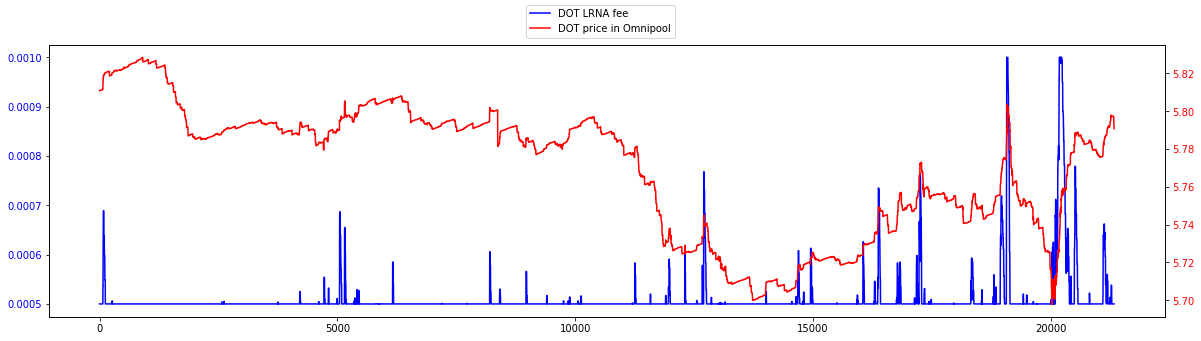

In [10]:
view_range = (0, len(blocks))
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(lrna_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} LRNA fee")
ax2 = ax.twinx()
ax2.plot(tkn_prices[view_range[0]: view_range[1]], color='red', label=f"{tkn} price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

In [11]:
# simulate with same trades and see if it comes out the same
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from datetime import datetime
import math
import random

lrna_fee_amplification=1.0
lrna_fee_decay=0.000005
lrna_fee_min=0.0005
lrna_fee_max=0.001
asset_fee_amplification=1.0
asset_fee_decay=0.00001
asset_fee_min=0.0025
asset_fee_max=0.05


initial_omnipool_tvl = 10000000
lrna_price_usd = tkn_prices[0] * historical_price_data[0][binance_tkn]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': tkn_liquidity, 'LRNA': tkn_lrna},
                'HDX': {'liquidity': 100000000, 'LRNA': 100000000 / 0.01 / lrna_price_usd},
                'USD': {'liquidity': 10000000, 'LRNA': 10000000 / lrna_price_usd}
            },
            lrna_fee=dynamicadd_lrna_fee(
                minimum=lrna_fee_min,
                amplification=lrna_fee_amplification,
                raise_oracle_name='fee_raise',
                decay=lrna_fee_decay,
                fee_max=lrna_fee_max,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=asset_fee_min,
                amplification=asset_fee_amplification,
                raise_oracle_name='fee_raise',
                decay=asset_fee_decay,
                fee_max=asset_fee_max,
            ),
            oracles={'fee_raise': 10},
            preferred_stablecoin = 'USD',
        )
    },
    agents={
        'trader': Agent(
            holdings={tkn: 1000000000 for tkn in ['HDX', tkn, 'USD', 'LRNA']}
        )
    }
)

In [12]:
print('simulating')
events = []
simulate_state = initial_state.copy()
simulate_state.pools['omnipool'].lrna_fee_this_block = {tkn: 0, 'HDX': 0, 'USD': 0}
simulate_state.pools['omnipool'].asset_fee_this_block = {tkn: 0, 'HDX': 0, 'USD': 0}
trade_index = 0
for block in blocks:
    while trade_index < len(trades_history) and trades_history[trade_index][0] == block:
        trade = trades_history[trade_index]
        amount = trade[1]
        lrna = trade[2]
        price = trade[3]
        trade_type = trade[6]
        simulate_state.pools['omnipool'].swap(
            agent=simulate_state.agents['trader'],
            tkn_sell=tkn if trade_type == 'buy' else 'LRNA',
            tkn_buy=tkn if trade_type == 'sell' else 'LRNA',
            sell_quantity = amount if trade_type == 'buy' else 0,
            buy_quantity = amount if trade_type == 'sell' else 0,
        )
        trade_index += 1
    simulate_state.pools['omnipool'].update()
    simulate_state.time_step = int(block)
    events.append(simulate_state.archive())

print('done')

simulating
done


In [13]:
len(list(filter(lambda x: x[6] == 'buy', trades_history)))

3763

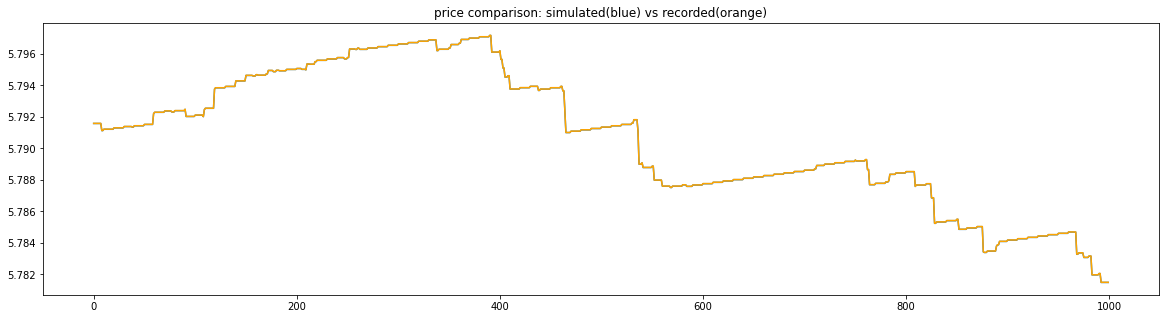

In [14]:
plt.figure(figsize=(20, 5))
# view_range = (10400, 10410)
view_range = (10000, 11000)
# view_range = (0, len(blocks))
plt.plot([event.pools['omnipool'].liquidity[tkn] / event.pools['omnipool'].lrna[tkn] for event in events[view_range[0]: view_range[1]]])
plt.plot(spot_price_history[view_range[0]: view_range[1]], color='orange')
plt.title('price comparison: simulated(blue) vs recorded(orange)')
plt.show()

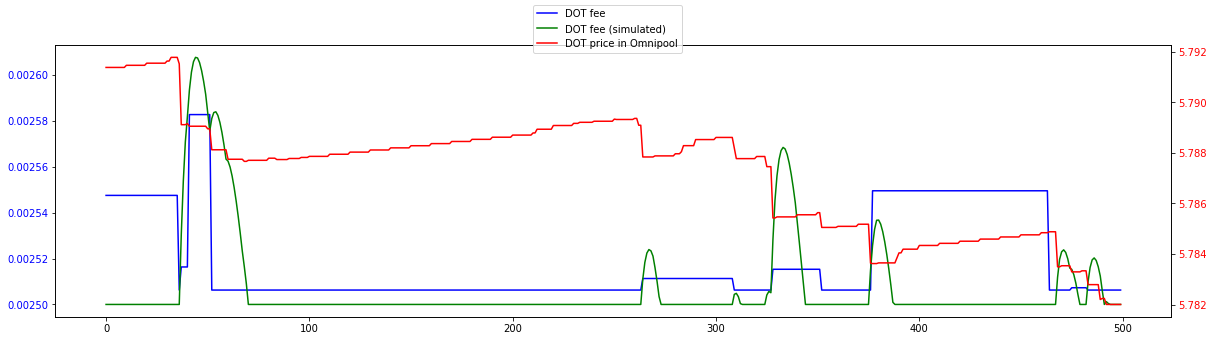

In [15]:
view_range = (10500, 11000)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(asset_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} fee")
ax.plot([event.pools['omnipool'].last_fee[tkn] for event in events[view_range[0]: view_range[1]]], color='green', label = f"{tkn} fee (simulated)")
ax2 = ax.twinx()
ax2.plot(tkn_prices[view_range[0]: view_range[1]], color='red', label=f"{tkn} price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
plt.show()

In [16]:
trades_history[0]

[5336816,
 16.3073406236,
 2.804916354908,
 5.810936571983159,
 '0.00049999999983814134',
 'LRNA',
 'buy',
 '2-Pool',
 0.0]

In [17]:
len(events), len(blocks), len(trades_history)

(21332, 21332, 4804)

In [18]:
active_blocks = [block[0] for block in trades_history]
active_block_fees = [[event.time_step, event.pools['omnipool'].last_fee[tkn]] for event in events if event.time_step in active_blocks]

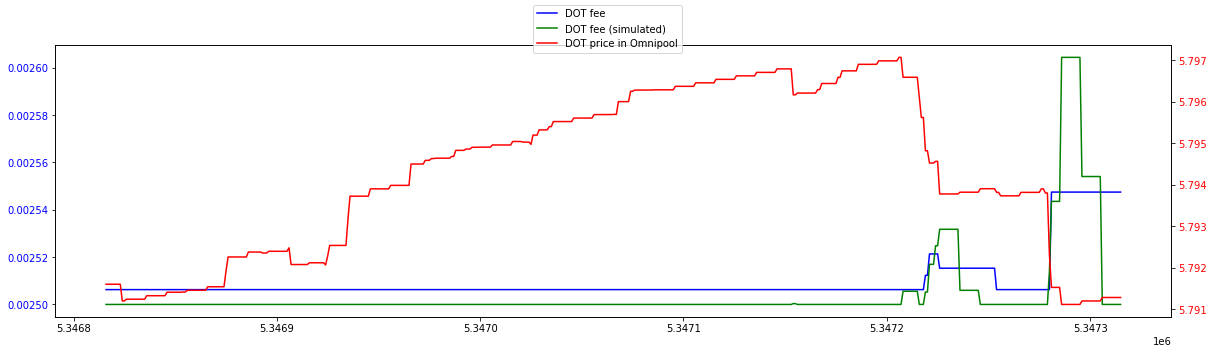

In [19]:
view_range = (0, 10500)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.tick_params(axis='y', labelcolor="blue")
ax.plot(blocks[view_range[0]: view_range[1]], asset_fees[view_range[0]: view_range[1]], color='blue', label=f"{tkn} fee")
ax.plot(blocks[view_range[0]: view_range[1]], fill_blocks(active_block_fees, 1)[view_range[0]: view_range[1]], color='green', label = f"{tkn} fee (simulated)")
ax2 = ax.twinx()
ax2.plot(blocks[view_range[0]: view_range[1]], tkn_prices[view_range[0]: view_range[1]], color='red', label=f"{tkn} price in Omnipool")
ax2.tick_params(axis='y', labelcolor="red")
fig.legend(loc='upper center')
# # buys
# for trade in [trade for trade in trades_history if trade[6] == 'buy' and trade[0] >= min_block + view_range[0] and trade[0] < min_block + view_range[1]]:
#     plt.arrow(trade[0], trade[3], 0, trade[8], color='orange', head_width=0.1, head_length=0.2, fc='orange', ec='orange')
# # sells
# for trade in [trade for trade in trades_history if trade[6] == 'sell' and trade[0] >= min_block + view_range[0] and trade[0] < min_block + view_range[1]]:
#     plt.arrow(trade[0], trade[3], 1, trade[8], color='orange', head_width=0.1, head_length=0.2, fc='green', ec='green')
plt.show()

In [20]:
active_block_fees[-10:]

[[5358114, 0.0025],
 [5358116, 0.0025],
 [5358125, 0.0025],
 [5358126, 0.0025],
 [5358134, 0.002503950635092925],
 [5358136, 0.002503337121107921],
 [5358139, 0.0025082419903037696],
 [5358140, 0.0025270096342929157],
 [5358145, 0.002572832032019454],
 [5358146, 0.0025952091562211023]]

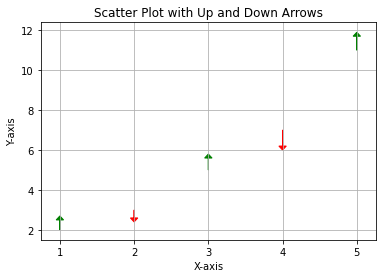

In [21]:
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]
arrow_lengths = [0.5, -0.4, 0.6, -0.8, 0.7]  # Positive for up, negative for down

# Create scatter plot
# plt.scatter(x, y, color='blue')

# Add arrows with different colors based on direction
for i in range(len(x)):
    color = 'green' if arrow_lengths[i] > 0 else 'red'
    plt.arrow(x[i], y[i], 0, arrow_lengths[i], head_width=0.1, head_length=0.2, fc=color, ec=color)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Up and Down Arrows')
plt.grid(True)
plt.show()


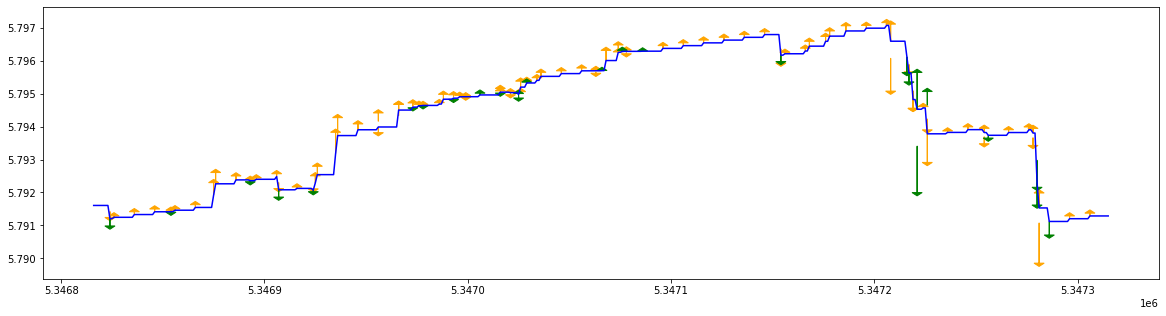

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(blocks[view_range[0]: view_range[1]], tkn_prices[view_range[0]: view_range[1]], color='blue')
# buys
last_direction = ''
for trade in [trade for trade in trades_history if trade[0] >= min_block + view_range[0] and trade[0] < min_block + view_range[1]]:
    if last_direction == 'buy':
        plt.arrow(trade[0], trade[3], 0, trade[8], color='orange', head_width=5, head_length=0.0001, fc='orange', ec='orange')
    last_direction = trade[6]
# sells
for trade in [trade for trade in trades_history if trade[0] >= min_block + view_range[0] and trade[0] < min_block + view_range[1]]:
    if last_direction == 'sell':
        plt.arrow(trade[0], trade[3], 0, trade[8], color='green', head_width=5, head_length=0.0001, fc='green', ec='green')
    last_direction = trade[6]
plt.show()

In [23]:
last_price = trades_history[0][3]
last_direction = ''
wrong_way = []
for trade in trades_history:
    price = trade[3]
    direction = trade[6]
    if last_direction == 'buy':
        if price < last_price:
            wrong_way += [trade]
    if last_direction == 'sell':
        if price > last_price:
            wrong_way += [trade]
            
    last_direction = direction
    last_price = price
print(len(wrong_way))

1012


In [24]:
len(trades_history)

4804

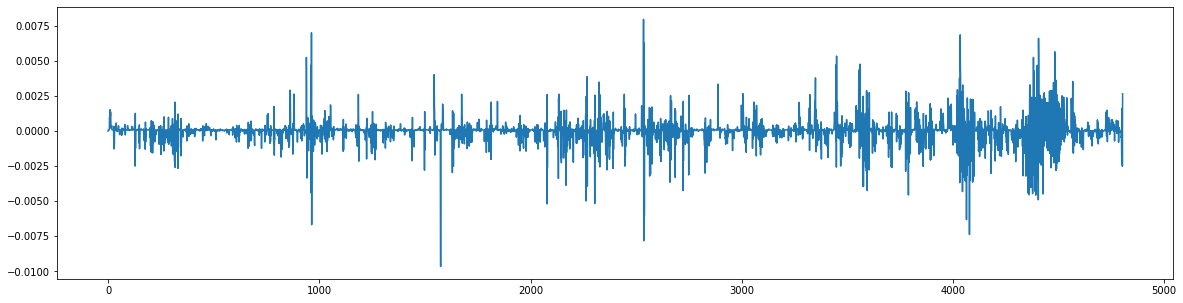

In [25]:
plt.figure(figsize=(20, 5))
plt.plot([trade[8] for trade in trades_history])

In [26]:
# trades_history[10404]
blocks.index(float(min_block + 10404))

10404

In [27]:
len(blocks)

21332

In [28]:
lrna_price_usd

35.81280209313221